# Proportion of treated patients by stroke type

## Code setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load data

Load the cleaned SSNAP extract data:

In [2]:
path_to_ssnap = '~/ssnap_data/clean_samuel_ssnap_extract_v2.csv'
df_ssnap = pd.read_csv(path_to_ssnap)

Check the available data in the file:

In [3]:
df_ssnap.columns

Index(['id', 'stroke_team', 'age', 'male', 'infarction',
       'onset_to_arrival_time', 'onset_known', 'precise_onset_known',
       'onset_during_sleep', 'arrive_by_ambulance',
       'call_to_ambulance_arrival_time', 'ambulance_on_scene_time',
       'ambulance_travel_to_hospital_time', 'ambulance_wait_time_at_hospital',
       'month', 'year', 'weekday', 'arrival_time_3_hour_period',
       'arrival_to_scan_time', 'thrombolysis', 'scan_to_thrombolysis_time',
       'thrombectomy', 'arrival_to_thrombectomy_time',
       'congestive_heart_failure', 'hypertension', 'atrial_fibrillation',
       'diabetes', 'prior_stroke_tia', 'afib_antiplatelet',
       'afib_anticoagulant', 'afib_vit_k_anticoagulant',
       'afib_doac_anticoagulant', 'afib_heparin_anticoagulant',
       'new_afib_diagnosis', 'prior_disability', 'stroke_severity',
       'nihss_complete', 'nihss_arrival_loc', 'nihss_arrival_loc_questions',
       'nihss_arrival_loc_commands', 'nihss_arrival_best_gaze',
       'nihss_

## Functions

The following function creates masks to say which patients meet which conditions.

Some patients have NIHSS of 10 or below and so would normally be classed as nLVO, but they also are recorded as having received a thrombectomy which should never happen for nLVO patients. So when thrombectomy is given, the patient is always classed as LVO regardless of their NIHSS score.

In [17]:
def make_masks(df):
    # Store masks in here:
    df_masks = pd.DataFrame()
    
    # Stroke type:
    df_masks['haemo'] = df['infarction'] == 0
    df_masks['lvo'] = (
        (
            (df['infarction'] == 1) & (df['stroke_severity'] > 10)
        ) | (df['thrombectomy'] == 1)
    )
    df_masks['nlvo'] = (
        (
            (df['infarction'] == 1) & (df['stroke_severity'] < 11)
        ) & (df['thrombectomy'] == 0)
    )

    # Treatment:
    df_masks['no_treatment'] = (df['thrombolysis'] == 0) & (df['thrombectomy'] == 0)
    df_masks['mt'] = df['thrombectomy'] == 1
    df_masks['ivt'] = df['thrombolysis'] == 1
    df_masks['ivt_mt'] = (df_masks['ivt'] & df_masks['mt'])

    return df_masks

The following function finds the proportions of patients who fall into each category. It uses the masks created in the previous function.

In [41]:
def make_props_from_masks(df, df_masks):
    # Store numbers of patients in here:
    dict_numbers = {}
    # Total number of patients:
    dict_numbers['total'] = len(df)
    # Stroke types:
    dict_numbers['haemo'] = len(df[df_masks['haemo']])
    dict_numbers['lvo'] = len(df[df_masks['lvo']])
    dict_numbers['nlvo'] = len(df[df_masks['nlvo']])
    # No treatment:
    dict_numbers['no_treatment'] = len(df[df_masks['no_treatment']])
    # No treatment split by stroke type:
    dict_numbers['haemo_no_treatment'] = len(df[df_masks['haemo'] & df_masks['no_treatment']])
    dict_numbers['lvo_no_treatment'] = len(df[df_masks['lvo'] & df_masks['no_treatment']])
    dict_numbers['nlvo_no_treatment'] = len(df[df_masks['nlvo'] & df_masks['no_treatment']])
    # Treatment:
    dict_numbers['mt'] = len(df[df_masks['mt']])
    dict_numbers['ivt'] = len(df[df_masks['ivt']])
    dict_numbers['ivt_mt'] = len(df[df_masks['ivt_mt']])
    # Treatment by stroke type:
    dict_numbers['lvo_ivt'] = len(df[df_masks['lvo'] & df_masks['ivt']])
    dict_numbers['nlvo_ivt'] = len(df[df_masks['nlvo'] & df_masks['ivt']])
    dict_numbers['lvo_ivt_only'] = len(df[df_masks['lvo'] & df_masks['ivt'] & ~df_masks['mt']])
    dict_numbers['lvo_mt_only'] = len(df[df_masks['lvo'] & ~df_masks['ivt'] & df_masks['mt']])
    dict_numbers['lvo_ivt_mt'] = len(df[df_masks['lvo'] & df_masks['ivt'] & df_masks['mt']])
    dict_numbers['nlvo_ivt_only'] = len(df[df_masks['nlvo'] & df_masks['ivt'] & ~df_masks['mt']])
    dict_numbers['nlvo_mt_only'] = len(df[df_masks['nlvo'] & ~df_masks['ivt'] & df_masks['mt']])
    dict_numbers['nlvo_ivt_mt'] = len(df[df_masks['nlvo'] & df_masks['ivt'] & df_masks['mt']])

    # Convert numbers into proportions:
    dict_props = {}
    for key, val in dict_numbers.items():
        dict_props[key] = val / dict_numbers['total']
    # Overwrite the total numbers of patients:
    dict_props['total'] = dict_numbers['total']

    # Add an extra proportion: how many people who received MT also received IVT?
    dict_props['mt_also_ivt'] = dict_numbers['ivt_mt'] / dict_numbers['mt']
    # Add an extra proportion: how many people who receive IVT have an LVO?
    dict_props['ivt_also_lvo'] = dict_numbers['lvo_ivt'] / dict_numbers['ivt']

    # Run sanity checks:
    sanity_checks(dict_props)
    return dict_props

The following function checks that the proportions add up as expected.

In [6]:
def sanity_checks(dict_props):
    # Number of decimal places to round to:
    d = 5

    if round(dict_props['haemo'], d) != round(dict_props['haemo_no_treatment'], 5):
        print('!   Haemorrhagic patients receive treatment.')
        for key in ['haemo', 'haemo_no_treatment']:
            print(f'    {key:20s}: {round(dict_props[key], d+1)}')

    p = (
        dict_props['lvo_ivt_only'] +
        dict_props['lvo_mt_only'] +
        dict_props['lvo_ivt_mt'] +
        dict_props['lvo_no_treatment']
    )
    if round(dict_props['lvo'], d) != round(p, d):
        print('!   LVO patients don\'t add up.')
        for key in ['lvo', 'lvo_ivt_only', 'lvo_mt_only', 'lvo_ivt_mt', 'lvo_no_treatment']:
            print(f'    {key:20s}: {round(dict_props[key], d+1)}')

    p = (
        dict_props['nlvo_ivt_only'] +
        dict_props['nlvo_mt_only'] +
        dict_props['nlvo_ivt_mt'] +
        dict_props['nlvo_no_treatment']
    )
    if round(dict_props['nlvo'], d) != round(p, d):
        print('!   nLVO patients don\'t add up.')
        for key in ['nlvo', 'nlvo_ivt_only', 'nlvo_mt_only', 'nlvo_ivt_mt', 'nlvo_no_treatment']:
            print(f'    {key:20s}: {round(dict_props[key], d+1)}')

    p = (
        dict_props['nlvo_ivt_only'] +
        dict_props['nlvo_ivt_mt'] +
        dict_props['lvo_ivt_only'] +
        dict_props['lvo_ivt_mt']
    )
    if round(dict_props['ivt'], d) != round(p, d):
        print('!   IVT patients don\'t add up.')
        for key in ['ivt', 'nlvo_ivt_only', 'nlvo_ivt_mt', 'lvo_ivt_only', 'lvo_ivt_mt']:
            print(f'    {key:20s}: {round(dict_props[key], d+1)}')

    p = (
        dict_props['nlvo_mt_only'] +
        dict_props['nlvo_ivt_mt'] +
        dict_props['lvo_mt_only'] +
        dict_props['lvo_ivt_mt']
    )
    if round(dict_props['mt'], d) != round(p, d):
        print('!   MT patients don\'t add up.')
        for key in ['mt', 'nlvo_mt_only', 'nlvo_ivt_mt', 'lvo_mt_only', 'lvo_ivt_mt']:
            print(f'    {key:20s}: {round(dict_props[key], d+1)}')

    p = (
        dict_props['nlvo_no_treatment'] +
        dict_props['lvo_no_treatment'] +
        dict_props['haemo_no_treatment']
    )
    if round(dict_props['no_treatment'], d) != round(p, d):
        print('!   No treatment patients don\'t add up.')
        for key in ['no_treatment', 'nlvo_no_treatment', 'lvo_no_treatment', 'haemo_no_treatment']:
            print(f'    {key:20s}: {round(dict_props[key], d+1)}')

    p = (
        dict_props['nlvo_ivt_only'] +
        dict_props['nlvo_mt_only'] +
        dict_props['nlvo_ivt_mt'] +
        dict_props['nlvo_no_treatment'] +
        dict_props['lvo_ivt_only'] +
        dict_props['lvo_mt_only'] +
        dict_props['lvo_ivt_mt'] +
        dict_props['lvo_no_treatment'] +
        dict_props['haemo_no_treatment']        
    )
    if round(1.0, d) != round(p, d):
        print('!   Total patients don\'t add up.')
        for key in ['nlvo_ivt_only', 'nlvo_mt_only', 'nlvo_ivt_mt', 'nlvo_no_treatment', 'lvo_ivt_only', 'lvo_mt_only', 'lvo_ivt_mt', 'lvo_no_treatment', 'haemo_no_treatment']:
            print(f'    {key:20s}: {round(dict_props[key], d+1)}')

## Results

Example for the full SSNAP data:

In [42]:
dict_props_full = make_props_from_masks(df_ssnap, make_masks(df_ssnap))

In [43]:
# Convert to Series for neater printing:
pd.Series(dict_props_full)

total                 358993.000000
haemo                      0.122153
lvo                        0.179432
nlvo                       0.698415
no_treatment               0.880457
haemo_no_treatment         0.122153
lvo_no_treatment           0.123665
nlvo_no_treatment          0.634639
mt                         0.012098
ivt                        0.114662
ivt_mt                     0.007217
lvo_ivt                    0.050887
nlvo_ivt                   0.063776
lvo_ivt_only               0.043669
lvo_mt_only                0.004880
lvo_ivt_mt                 0.007217
nlvo_ivt_only              0.063776
nlvo_mt_only               0.000000
nlvo_ivt_mt                0.000000
mt_also_ivt                0.596592
ivt_also_lvo               0.443797
dtype: float64

Calculate the proportions separately for various onset-to-arrival time cutoffs.

In [81]:
dict_props_by_time = {}

for time in np.arange(1.0, 25.0, 1.0):
    df_here = df_ssnap[df_ssnap['onset_to_arrival_time'] < time * 60.0].copy().reset_index()
    dict_props_here = make_props_from_masks(df_here, make_masks(df_here))
    dict_props_by_time[f'{time:.0f}'] = dict_props_here

# Also store the full results:
dict_props_by_time['inf'] = dict_props_full

df_props_by_time = pd.DataFrame(dict_props_by_time).T
df_props_by_time.index.name = 'expected_onset_to_arrival_time'
# Round values to 5 d.p. (should be plenty):
df_props_by_time = np.round(df_props_by_time, 5)

In [82]:
df_props_by_time.head(3).T

expected_onset_to_arrival_time,1,2,3
total,18826.00000,82627.00000,117084.00000
haemo,0.15208,0.15241,0.14896
lvo,0.31972,0.28677,0.26338
nlvo,0.52821,0.56082,0.58766
no_treatment,0.59652,0.64456,0.67588
haemo_no_treatment,0.15208,0.15241,0.14896
lvo_no_treatment,0.10900,0.11536,0.11378
nlvo_no_treatment,0.33544,0.37679,0.41314
mt,0.03984,0.03135,0.02719
ivt,0.39307,0.34753,0.31684


In [83]:
df_props_by_time.tail(3).T

expected_onset_to_arrival_time,23,24,inf
total,214667.00000,216225.00000,358993.00000
haemo,0.12934,0.12893,0.12215
lvo,0.21052,0.20949,0.17943
nlvo,0.66015,0.66159,0.69841
no_treatment,0.80434,0.80575,0.88046
haemo_no_treatment,0.12934,0.12893,0.12215
lvo_no_treatment,0.12023,0.11985,0.12367
nlvo_no_treatment,0.55477,0.55697,0.63464
mt,0.01844,0.01831,0.01210
ivt,0.18905,0.18769,0.11466


## Save results

In [84]:
df_props_by_time.to_csv('treatment_proportions_by_arrival_time.csv')

## Quick plots

### Treated patients

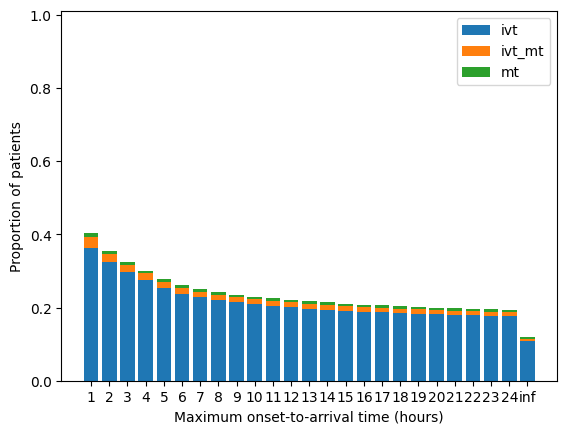

In [74]:
fig, ax = plt.subplots()

bottoms = np.full(len(df_props_by_time), 0.0)
for c, col in enumerate(['ivt', 'ivt_mt', 'mt']):
    heights = df_props_by_time[col].copy()
    if col == 'ivt_mt':
        bottoms -= df_props_by_time['ivt_mt'].copy()
    elif col == 'mt':
        heights -= df_props_by_time['ivt_mt']
    ax.bar(x=df_props_by_time.index, height=heights, bottom=bottoms, label=col)
    bottoms += heights

ax.set_ylim(0, 1.01)
ax.legend()
ax.set_xlabel('Maximum onset-to-arrival time (hours)')
ax.set_ylabel('Proportion of patients')
ax.set_title('Patients receiving treatment')

plt.show()

### Thrombolysed patients

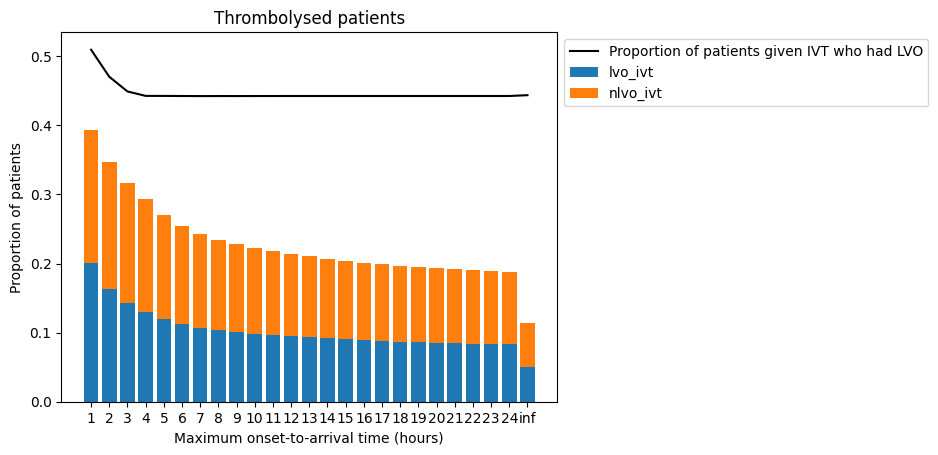

In [76]:
fig, ax = plt.subplots()

bottoms = np.full(len(df_props_by_time), 0.0)
for c, col in enumerate(['lvo_ivt', 'nlvo_ivt']):
    ax.bar(x=df_props_by_time.index, height=df_props_by_time[col], bottom=bottoms, label=col)
    bottoms += df_props_by_time[col]

ax.plot(
    df_props_by_time.index,
    df_props_by_time['ivt_also_lvo'],
    label='Proportion of patients given IVT who had LVO',
    color='k'
)

# ax.set_ylim(0, 1)
ax.legend(bbox_to_anchor=[1.0, 1.0], loc='upper left')
ax.set_xlabel('Maximum onset-to-arrival time (hours)')
ax.set_ylabel('Proportion of patients')
ax.set_title('Patients receiving thrombolysis')

plt.show()

I expect the line plateaus after around 4 hours because no more patients (in absolute numbers) receive thrombolysis after that point. The bars keep decreasing in size because more patients (in absolute numbers) join the subgroup but none of them receive IVT.

Check the values in the line:

In [78]:
df_props_by_time['ivt_also_lvo']

expected_onset_to_arrival_time
1      0.509595
2      0.470451
3      0.449174
4      0.442766
5      0.442731
6      0.442586
7      0.442475
8      0.442534
9      0.442510
10     0.442535
11     0.442572
12     0.442599
13     0.442599
14     0.442599
15     0.442599
16     0.442599
17     0.442599
18     0.442599
19     0.442599
20     0.442599
21     0.442599
22     0.442599
23     0.442599
24     0.442599
inf    0.443797
Name: ivt_also_lvo, dtype: float64

The value holds steady at 44.3%.

### Thrombectomised patients

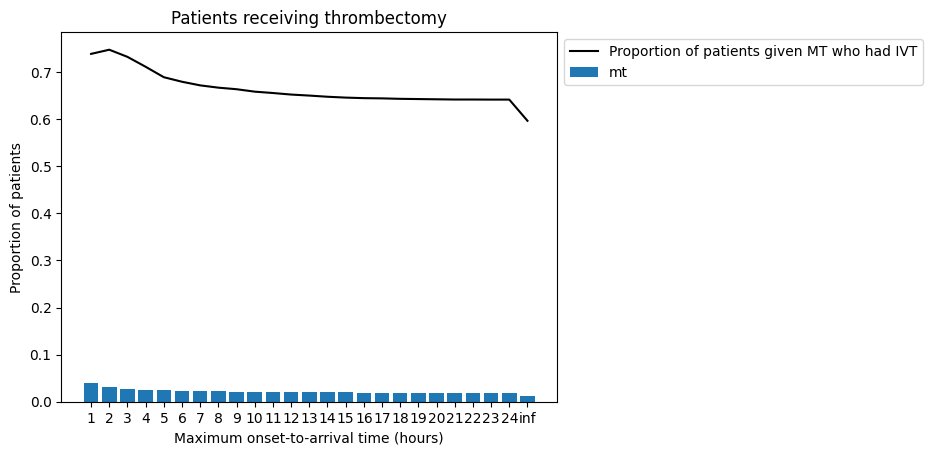

In [80]:
fig, ax = plt.subplots()

bottoms = np.full(len(df_props_by_time), 0.0)
for c, col in enumerate(['mt']):
    ax.bar(x=df_props_by_time.index, height=df_props_by_time[col], bottom=bottoms, label=col)
    bottoms += df_props_by_time[col]

ax.plot(
    df_props_by_time.index,
    df_props_by_time['mt_also_ivt'],
    label='Proportion of patients given MT who had IVT',
    color='k'
)

# ax.set_ylim(0, 1)
ax.legend(bbox_to_anchor=[1.0, 1.0], loc='upper left')
ax.set_xlabel('Maximum onset-to-arrival time (hours)')
ax.set_ylabel('Proportion of patients')
ax.set_title('Patients receiving thrombectomy')

plt.show()

The line here takes longer to plateau, not reaching a steady value within the first 12 hours after stroke onset.

Check the values in the line:

In [79]:
df_props_by_time['mt_also_ivt']

expected_onset_to_arrival_time
1      0.738667
2      0.747490
3      0.732328
4      0.711258
5      0.689126
6      0.679473
7      0.671792
8      0.666930
9      0.663613
10     0.658448
11     0.655564
12     0.652286
13     0.650115
14     0.647629
15     0.645817
16     0.644670
17     0.644180
18     0.643201
19     0.642713
20     0.642225
21     0.641738
22     0.641738
23     0.641576
24     0.641576
inf    0.596592
Name: mt_also_ivt, dtype: float64

The value falls towards 64.2%.

## Conclusion

We have saved a copy of the patient proportions at various onset-to-arrival cutoff times.

Some useful values for future use:

| Property | Value at 6hr | Value at 24hr | Recommended value to use |
| --- | --- | --- | --- |
| Proportion of patients with IVT who had LVO | 0.44259 | 0.44260 | 44.3% |
| Proportion of patients with MT who also had IVT | 0.67947 | 0.64158 | 64.2% |